# Análisis de polarización

Partiendo de los resultados de las primeras vueltas presidenciales de 2023 y 2025, este proyecto explora distintas maneras de medir la polarización.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Configuraciones generales
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")  
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df_cantonal_2025 = pd.read_excel("resultados_finales/porcentajes_cantonal_2025.xlsx")
df_cantonal_2023 = pd.read_excel("resultados_finales/porcentajes_cantonal_2023.xlsx")
df_parroquial_2025 = pd.read_excel("resultados_finales/resultados_parroquiales_2025.xlsx")
df_parroquial_2023 = pd.read_excel("resultados_finales/resultados_parroquiales_2023.xlsx")


In [3]:
# --- PARROQUIAL 2025 ---
pct_cols_2025 = df_parroquial_2025.columns[df_parroquial_2025.columns.str.startswith('%')].tolist()
df_porcentajes_parroquial_2025 = df_parroquial_2025[["ID_Parroquia"] + pct_cols_2025].copy()

# --- PARROQUIAL 2023 ---
pct_cols_2023 = df_parroquial_2023.columns[df_parroquial_2023.columns.str.startswith('%')].tolist()
df_porcentajes_parroquial_2023 = df_parroquial_2023[["ID_Parroquia"] + pct_cols_2023].copy()
# --- PARROQUIAL 2025 ---
cols_2025 = ['ID_Parroquia'] + [col for col in df_porcentajes_parroquial_2025.columns if col != 'ID_Parroquia']
df_porcentajes_parroquial_2025 = df_porcentajes_parroquial_2025[cols_2025]

# --- PARROQUIAL 2023 ---
cols_2023 = ['ID_Parroquia'] + [col for col in df_porcentajes_parroquial_2023.columns if col != 'ID_Parroquia']
df_porcentajes_parroquial_2023 = df_porcentajes_parroquial_2023[cols_2023]



# Cálculo Número Efectivo de Candidatos (NEC)

El Número Efectivo de Candidatos (NEC) es una adaptación del índice de Laakso y Taagepera, utilizado para estimar el número de opciones competitivas en una elección. Refleja cuántos candidatos tuvieron un peso real en la contienda electoral. Por ejemplo, un NEC de 4 indica que la competencia electoral fue equivalente a tener 4 candidatos con niveles significativos de apoyo. En un escenario de polarización, el NEC debería tender hacia dos. 

In [5]:
# --- Define la función para calcular el NEC ---

def calcular_numero_efectivo_candidatos(df, id_columna, blanco_columna, nuevo_nombre_col='NEC'):
    """
    Calcula el Número Efectivo de Candidatos (NEC) para cada fila de un DataFrame.

    Args:
        df (pd.DataFrame): El DataFrame con los porcentajes de voto.
        id_columna (str): El nombre de la columna que identifica la circunscripción.
        blanco_columna (str): El nombre de la columna con el porcentaje de voto en blanco.
        nuevo_nombre_col (str): El nombre para la nueva columna con el resultado NEC.

    Returns:
        pd.DataFrame: El DataFrame original con la nueva columna NEC añadida.
    """
    # Identificar las columnas que corresponden a los candidatos
    # Son todas las columnas EXCEPTO la de ID y la de voto en blanco
    columnas_candidatos = [col for col in df.columns if col not in [id_columna, blanco_columna]]

    # Seleccionar solo los datos de los candidatos
    df_candidatos = df[columnas_candidatos]


    df_proporciones = df_candidatos / 100.0

    # Calcular el cuadrado de cada proporción
    df_cuadrados = df_proporciones.pow(2)

    # Sumar los cuadrados de las proporciones para cada fila (circunscripción)
    # axis=1 indica que la suma se hace a lo largo de las columnas para cada fila
    suma_cuadrados = df_cuadrados.sum(axis=1)

    # Calcular el NEC (1 / suma de cuadrados)
    df[nuevo_nombre_col] = np.where(suma_cuadrados > 0, 1 / suma_cuadrados, 0)

    return df

In [6]:
df_porcentajes_parroquial_2023 = calcular_numero_efectivo_candidatos(
    df_porcentajes_parroquial_2023,
    id_columna="ID_Parroquia",
    blanco_columna="%BLANCOS",
    nuevo_nombre_col='NEC23' 
)


In [7]:
df_porcentajes_parroquial_2025 = calcular_numero_efectivo_candidatos(
    df_porcentajes_parroquial_2025,
    id_columna="ID_Parroquia",
    blanco_columna="%Blancos",
    nuevo_nombre_col='NEC25' 
)

# Cálculo indicador de polarización

Este indicador mide qué tan polarizada fue una elección comparando los resultados reales en cada circunscripción con un escenario ideal de polarización, en el que los dos candidatos más votados obtienen exactamente el 50% de los votos entre ambos.

Vector de polarización ideal:

> (0.5, 0.5, 0, 0, … , 0)


La comparación se realiza utilizando la distancia L1 (o distancia Manhattan) entre el vector de resultados reales (ordenado de mayor a menor) y el vector ideal.

El valor del indicador se normaliza para que varíe entre 0 y 1:

Polarización máxima → indicador cercano a 1

Polarización mínima (votos muy distribuidos) → indicador cercano a 0

Cuanto más cercano a 1, más polarizado fue el escenario electoral.

In [8]:
def calcular_polarizacion_l1(df, id_col, blank_col, cand1_col, cand2_col, output_col_name='Polarizacion_L1'):
    """
    Calcula un indicador de polarización L1, identificando automáticamente
    las columnas de candidatos al excluir las columnas de ID y voto en blanco.

    Args:
        df (pd.DataFrame): El DataFrame con los porcentajes de voto.
        id_col (str): Nombre de la columna de identificación (será excluida).
        blank_col (str): Nombre de la columna de voto en blanco (será excluida).
        cand1_col (str): Nombre de la columna del primer candidato principal.
        cand2_col (str): Nombre de la columna del segundo candidato principal.
        output_col_name (str): Nombre para la nueva columna con el indicador.

    Returns:
        pd.DataFrame: El DataFrame original con la nueva columna añadida,
                      o el DataFrame original sin modificar si faltan columnas clave.
    """
    print(f"Intentando calcular '{output_col_name}' (con detección automática de candidatos)...")

    # 1. Verificar que las columnas clave existan
    required_cols = [id_col, blank_col, cand1_col, cand2_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Faltan las siguientes columnas clave en el DataFrame: {missing_cols}")
        print(f"No se pudo calcular '{output_col_name}'.")
        return df

    # 2. Identificar dinámicamente las columnas de candidatos
    #    Son todas las columnas EXCEPTO la de ID y la de voto en blanco
    all_df_cols = df.columns.tolist()
    non_candidate_cols = [id_col, blank_col]
    candidate_cols = [col for col in all_df_cols if col not in non_candidate_cols]

    # Verificar que los candidatos principales estén entre las columnas identificadas
    if cand1_col not in candidate_cols or cand2_col not in candidate_cols:
         print(f"Error: '{cand1_col}' o '{cand2_col}' no se encuentran entre las columnas "
               f"identificadas como candidatos (después de excluir '{id_col}' y '{blank_col}').")
         print("Verifica los nombres de las columnas o la estructura del DataFrame.")
         print(f"No se pudo calcular '{output_col_name}'.")
         return df

    print(f"Columnas de candidatos identificadas automáticamente: {len(candidate_cols)}")

    # 3. Seleccionar y procesar SOLO las columnas de candidatos
    #    Usar .copy() para evitar SettingWithCopyWarning
    df_candidates = df[candidate_cols].copy()
    proportions_all = df_candidates.fillna(0) / 100.0

    # 4. Extraer proporciones de los principales (v1, v2)
    #    Acceder a través de proportions_all asegura que usamos las columnas correctas
    v1 = proportions_all[cand1_col]
    v2 = proportions_all[cand2_col]

    # 5. Calcular la suma de proporciones de los OTROS candidatos
    other_candidate_cols = [col for col in candidate_cols if col not in [cand1_col, cand2_col]]
    sum_others = proportions_all[other_candidate_cols].sum(axis=1)

    # 6. Calcular los componentes L1 y el indicador final
    l1_comp1 = abs(v1 - 0.5)
    l1_comp2 = abs(v2 - 0.5)
    l1_comp3 = sum_others
    l1_distance = l1_comp1 + l1_comp2 + l1_comp3
    df[output_col_name] = 1 - l1_distance / 2

    print(f"Cálculo de '{output_col_name}' completado.")
    return df


# --- Definición de Nombres de Columnas Comunes ---
columna_id = 'ID_Parroquia'

# Definición de Candidatos Principales (Asegúrate que estos nombres existen como columnas)
candidato_principal_1 = '%DANIEL NOBOA AZIN' # Ajusta si es necesario
candidato_principal_2 = '%LUISA GONZALEZ'   # Ajusta si es necesario



In [9]:
df_porcentajes_parroquial_2025 = calcular_polarizacion_l1(
    df=df_porcentajes_parroquial_2025,
    id_col=columna_id,
    blank_col="%Blancos",
    cand1_col=candidato_principal_1,
    cand2_col=candidato_principal_2,
    output_col_name='Polarizacion_L1_2025'
)

# Mostrar resultados (asegurándose de que las columnas existan)
display_cols_25 = [columna_id, candidato_principal_1, candidato_principal_2, 'Polarizacion_L1_2025']
# Intentar añadir 'Parroquia' si existe (ajusta 'Parroquia' si se llama diferente)
if 'Parroquia' in df_porcentajes_parroquial_2025.columns:
     display_cols_25.insert(1, 'Parroquia')
existing_display_cols_25 = [col for col in display_cols_25 if col in df_porcentajes_parroquial_2025.columns]
if 'Polarizacion_L1_2025' in df_porcentajes_parroquial_2025.columns: # Solo mostrar si se calculó
    print("Vista previa df_porcentajes_parroquial_2025:")
    print(df_porcentajes_parroquial_2025[existing_display_cols_25].head())
else:
    print("No se generó la columna Polarizacion_L1_2025 debido a errores previos.")


print("\n" + "="*70 + "\n")




Intentando calcular 'Polarizacion_L1_2025' (con detección automática de candidatos)...
Columnas de candidatos identificadas automáticamente: 17
Cálculo de 'Polarizacion_L1_2025' completado.
Vista previa df_porcentajes_parroquial_2025:
   ID_Parroquia  %DANIEL NOBOA AZIN  %LUISA GONZALEZ  Polarizacion_L1_2025
0             5           23.091603        58.015267              0.749693
1            10           26.211495        63.796018              0.774437
2            15           44.956027        39.213658              0.841042
3            20           12.043274        36.088998              0.494335
4            25           58.010681        21.317312              0.714053




In [10]:
df_porcentajes_parroquial_2023 = calcular_polarizacion_l1(
    df=df_porcentajes_parroquial_2023,
    id_col=columna_id,
    blank_col="%BLANCOS",
    cand1_col=candidato_principal_1,
    cand2_col=candidato_principal_2,
    output_col_name='Polarizacion_L1_2023'
)

# Mostrar resultados (asegurándose de que las columnas existan)
display_cols_23 = [columna_id, candidato_principal_1, candidato_principal_2, 'Polarizacion_L1_2023']
# Intentar añadir 'Parroquia' si existe (ajusta 'Parroquia' si se llama diferente)
if 'Parroquia' in df_porcentajes_parroquial_2023.columns:
     display_cols_23.insert(1, 'Parroquia')
existing_display_cols_23 = [col for col in display_cols_23 if col in df_porcentajes_parroquial_2023.columns]
if 'Polarizacion_L1_2023' in df_porcentajes_parroquial_2023.columns: # Solo mostrar si se calculó
    print("Vista previa df_porcentajes_parroquial_2023:")
    print(df_porcentajes_parroquial_2023[existing_display_cols_23].head())
else:
     print("No se generó la columna Polarizacion_L1_2023 debido a errores previos.")




Intentando calcular 'Polarizacion_L1_2023' (con detección automática de candidatos)...
Columnas de candidatos identificadas automáticamente: 9
Cálculo de 'Polarizacion_L1_2023' completado.
Vista previa df_porcentajes_parroquial_2023:
   ID_Parroquia  %DANIEL NOBOA AZIN  %LUISA GONZALEZ  Polarizacion_L1_2023
0             5            8.479263        52.626728              0.594861
1            10           18.439988        50.561259              0.688798
2            15           20.615723        29.631666              0.483938
3            20            6.218422        44.364555              0.521297
4            25           10.947223        19.797188              0.291376


# Cálculo polarización vs. fragmentación

Cálculo del Indicador de Polarización vs. Fragmentación
Este indicador compara los resultados electorales reales con dos escenarios extremos:

Escenario de polarización ideal: 

> (0.5, 0.5, 0, 0, ..., 0)

Escenario de fragmentación ideal (todos los candidatos reciben una proporción igual de votos): 

> (1/n, 1/n, 1/n, ..., 1/n), donde n es el número de candidatos

Se calcula la distancia entre el vector de resultados reales y ambos escenarios. Luego se normaliza para ubicar el resultado entre 0 y 1:

Valor cercano a 1 indica mayor polarización

Valor cercano a 0 indica mayor fragmentación

Este enfoque ayuda a interpretar correctamente los escenarios donde el indicador de polarización simple tiende a cero, permitiendo distinguir entre baja polarización real y alta fragmentación.

In [11]:


def calcular_polarizacion_comparativa_l1(df, id_col, blank_col, cand1_col, cand2_col, output_col_name='PolarizacionComparativa_L1'):
    """
    Calcula un indicador de polarización comparando la distancia L1 del vector
    de votos real a dos escenarios ideales: polarización perfecta (0.5, 0.5, 0...)
    y fragmentación perfecta (1/n, 1/n, ...).

    El indicador tiende a 1 si está más cerca de la polarización perfecta,
    y a 0 si está más cerca de la fragmentación perfecta.

    Args:
        df (pd.DataFrame): DataFrame con porcentajes de voto.
        id_col (str): Nombre de la columna de identificación.
        blank_col (str): Nombre de la columna de voto en blanco.
        cand1_col (str): Nombre de la columna del primer candidato principal.
        cand2_col (str): Nombre de la columna del segundo candidato principal.
        output_col_name (str): Nombre para la nueva columna con el indicador.

    Returns:
        pd.DataFrame: DataFrame original con la nueva columna añadida,
                      o el original sin modificar si faltan columnas o n < 2.
    """
    print(f"Intentando calcular '{output_col_name}'...")

    # 1. Verificar columnas clave
    required_cols = [id_col, blank_col, cand1_col, cand2_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Faltan columnas clave: {missing_cols}. No se puede calcular.")
        return df

    # 2. Identificar columnas de candidatos
    all_df_cols = df.columns.tolist()
    non_candidate_cols = [id_col, blank_col]
    candidate_cols = [col for col in all_df_cols if col not in non_candidate_cols]

    # Verificar que los candidatos principales están entre los identificados
    if cand1_col not in candidate_cols or cand2_col not in candidate_cols:
        print(f"Error: '{cand1_col}' o '{cand2_col}' no encontrados entre las columnas de candidatos.")
        print("Verifica nombres o estructura del DataFrame. No se puede calcular.")
        return df

    n_candidates = len(candidate_cols)
    print(f"Número de columnas de candidatos identificadas: {n_candidates}")

    # 3. Validar número de candidatos
    if n_candidates < 2:
        print(f"Error: Se necesitan al menos 2 candidatos para calcular este indicador (encontrados: {n_candidates}).")
        print(f"No se pudo calcular '{output_col_name}'.")
        # Opcionalmente, podrías llenar con NaN en lugar de no añadir la columna:
        # df[output_col_name] = np.nan
        return df

    # 4. Calcular proporciones (vector 'p' para cada fila)
    #   Usar .copy() para evitar SettingWithCopyWarning
    proportions_df = df[candidate_cols].copy().fillna(0) / 100.0

    # 5. Calcular Distancia al Escenario de Polarización Perfecta (L1(p, P))
    p_cand1 = proportions_df[cand1_col]
    p_cand2 = proportions_df[cand2_col]
    other_candidate_cols = [col for col in candidate_cols if col not in [cand1_col, cand2_col]]
    sum_others = proportions_df[other_candidate_cols].sum(axis=1)
    dist_polarization = abs(p_cand1 - 0.5) + abs(p_cand2 - 0.5) + sum_others
    # Nota: Esto es idéntico a la L1_distance calculada en la función anterior.

    # 6. Calcular Distancia al Escenario de Fragmentación Perfecta (L1(p, F))
    ideal_frag_prop = 1.0 / n_candidates
    # abs(proportions_df - ideal_frag_prop) calcula la diferencia absoluta para cada celda
    # .sum(axis=1) suma estas diferencias absolutas a lo largo de cada fila
    dist_fragmentation = abs(proportions_df - ideal_frag_prop).sum(axis=1)

    # 7. Calcular el Indicador Comparativo Normalizado
    total_dist = dist_polarization + dist_fragmentation
    # Indicador = dist_fragmentation / total_dist
    # Si dist_polarization es pequeña -> total_dist ≈ dist_fragmentation -> Indicador ≈ 1
    # Si dist_fragmentation es pequeña -> total_dist ≈ dist_polarization -> Indicador ≈ 0
    # Usamos np.where para manejar el caso total_dist == 0 (lo que implica p=P y p=F)
    # En este caso (n=2, p=[0.5, 0.5]), ambas distancias son 0. Asignamos 1 (polarización).
    df[output_col_name] = np.where(total_dist > 1e-9, # Usar tolerancia pequeña por floats
                                     dist_fragmentation / total_dist,
                                     1.0) # Asignar 1 si ambas distancias son (casi) cero

    print(f"Cálculo de '{output_col_name}' completado.")
    return df


# --- Definición de Nombres de Columnas Comunes ---
columna_id = 'ID_Parroquia'

# Definición de Candidatos Principales (Asegúrate que estos nombres existen como columnas)
candidato_principal_1 = '%DANIEL NOBOA AZIN' # Ajusta si es necesario
candidato_principal_2 = '%LUISA GONZALEZ'   # Ajusta si es necesario

In [12]:
# --- Aplicación a df_porcentajes_parroquial_2025 ---
print("\nProcesando df_porcentajes_parroquial_2025...")
df_porcentajes_parroquial_2025 = calcular_polarizacion_comparativa_l1(
    df=df_porcentajes_parroquial_2025,
    id_col=columna_id,
    blank_col="%Blancos",
    cand1_col=candidato_principal_1,
    cand2_col=candidato_principal_2,
    output_col_name='PolarizacionComparativa_L1_2025'
)

# Mostrar resultados
display_cols_25 = [columna_id, candidato_principal_1, candidato_principal_2, 'PolarizacionComparativa_L1_2025']
if 'Parroquia' in df_porcentajes_parroquial_2025.columns:
     display_cols_25.insert(1, 'Parroquia')
existing_display_cols_25 = [col for col in display_cols_25 if col in df_porcentajes_parroquial_2025.columns]
if 'PolarizacionComparativa_L1_2025' in df_porcentajes_parroquial_2025.columns:
    print("Vista previa df_porcentajes_parroquial_2025:")
    print(df_porcentajes_parroquial_2025[existing_display_cols_25].head())
else:
    print("No se generó la columna PolarizacionComparativa_L1_2025.")

# --- Aplicación a df_porcentajes_parroquial_2023 ---
print("Procesando df_porcentajes_parroquial_2023...")
df_porcentajes_parroquial_2023 = calcular_polarizacion_comparativa_l1(
    df=df_porcentajes_parroquial_2023,
    id_col=columna_id,
    blank_col="%BLANCOS",
    cand1_col=candidato_principal_1,
    cand2_col=candidato_principal_2,
    output_col_name='PolarizacionComparativa_L1_2023'
)

# Mostrar resultados
display_cols_23 = [columna_id, candidato_principal_1, candidato_principal_2, 'PolarizacionComparativa_L1_2023']
if 'Parroquia' in df_porcentajes_parroquial_2023.columns:
     display_cols_23.insert(1, 'Parroquia')
existing_display_cols_23 = [col for col in display_cols_23 if col in df_porcentajes_parroquial_2023.columns]
if 'PolarizacionComparativa_L1_2023' in df_porcentajes_parroquial_2023.columns:
    print("Vista previa df_porcentajes_parroquial_2023:")
    print(df_porcentajes_parroquial_2023[existing_display_cols_23].head())
else:
     print("No se generó la columna PolarizacionComparativa_L1_2023.")

print("\n" + "="*70 + "\n")
print("Proceso de polarización comparativa completado.")


Procesando df_porcentajes_parroquial_2025...
Intentando calcular 'PolarizacionComparativa_L1_2025'...
Número de columnas de candidatos identificadas: 18
Cálculo de 'PolarizacionComparativa_L1_2025' completado.
Vista previa df_porcentajes_parroquial_2025:
   ID_Parroquia  %DANIEL NOBOA AZIN  %LUISA GONZALEZ  \
0             5           23.091603        58.015267   
1            10           26.211495        63.796018   
2            15           44.956027        39.213658   
3            20           12.043274        36.088998   
4            25           58.010681        21.317312   

   PolarizacionComparativa_L1_2025  
0                         0.737828  
1                         0.776563  
2                         0.817989  
3                         0.586450  
4                         0.715173  
Procesando df_porcentajes_parroquial_2023...
Intentando calcular 'PolarizacionComparativa_L1_2023'...
Número de columnas de candidatos identificadas: 10
Cálculo de 'PolarizacionComparat

In [13]:
# --- Aplicación a df_porcentajes_parroquial_2023 ---
print("Procesando df_porcentajes_parroquial_2023...")
df_porcentajes_parroquial_2023 = calcular_polarizacion_comparativa_l1(
    df=df_porcentajes_parroquial_2023,
    id_col=columna_id,
    blank_col="%BLANCOS",
    cand1_col=candidato_principal_1,
    cand2_col=candidato_principal_2,
    output_col_name='PolarizacionComparativa_L1_2023'
)

# Mostrar resultados
display_cols_23 = [columna_id, candidato_principal_1, candidato_principal_2, 'PolarizacionComparativa_L1_2023']
if 'Parroquia' in df_porcentajes_parroquial_2023.columns:
     display_cols_23.insert(1, 'Parroquia')
existing_display_cols_23 = [col for col in display_cols_23 if col in df_porcentajes_parroquial_2023.columns]
if 'PolarizacionComparativa_L1_2023' in df_porcentajes_parroquial_2023.columns:
    print("Vista previa df_porcentajes_parroquial_2023:")
    print(df_porcentajes_parroquial_2023[existing_display_cols_23].head())
else:
     print("No se generó la columna PolarizacionComparativa_L1_2023.")


Procesando df_porcentajes_parroquial_2023...
Intentando calcular 'PolarizacionComparativa_L1_2023'...
Número de columnas de candidatos identificadas: 11
Cálculo de 'PolarizacionComparativa_L1_2023' completado.
Vista previa df_porcentajes_parroquial_2023:
   ID_Parroquia  %DANIEL NOBOA AZIN  %LUISA GONZALEZ  \
0             5            8.479263        52.626728   
1            10           18.439988        50.561259   
2            15           20.615723        29.631666   
3            20            6.218422        44.364555   
4            25           10.947223        19.797188   

   PolarizacionComparativa_L1_2023  
0                         0.550038  
1                         0.635769  
2                         0.463443  
3                         0.495443  
4                         0.387809  


# Indicador con distancia euclidiana fragmentación vs polarización

Este indicador compara los resultados reales de una elección con dos escenarios de referencia:

Escenario de polarización ideal: 

> (0.5, 0.5, 0, 0, ..., 0)

Escenario de fragmentación ideal: 

> (1/n, 1/n, 1/n, ..., 1/n), donde n es el número de candidatos

Se utiliza la distancia euclidiana para medir la cercanía del vector real a cada uno de estos extremos. El indicador final se normaliza para ubicarse en el rango de 0 a 1:

- 0 → Alta fragmentación (más cerca del escenario fragmentado)

- 1 → Alta polarización (más cerca del escenario polarizado)

A diferencia del enfoque con distancia L1, el uso de distancia euclidiana hace que el indicador sea más sensible a las diferencias entre las proporciones de votos, lo que mejora la discriminación entre escenarios intermedios.

In [14]:
# --- Función para Calcular Polarización Comparativa Euclidiana (Revisada) ---

def calcular_polarizacion_comparativa_euclid(df, id_col, blank_col, cand1_col, cand2_col, output_col_name='PolarizacionComp_Euclid'):
    """
    Calcula un indicador de polarización comparando la distancia Euclidiana (L2)
    del vector de votos real a dos escenarios ideales: polarización perfecta (P)
    y fragmentación perfecta (F).

    El indicador tiende a 1 si está más cerca de P, y a 0 si está más cerca de F.

    Args:
        df (pd.DataFrame): DataFrame con porcentajes de voto.
        id_col (str): Nombre de la columna de identificación.
        blank_col (str): Nombre de la columna de voto en blanco.
        cand1_col (str): Nombre de la columna del primer candidato principal.
        cand2_col (str): Nombre de la columna del segundo candidato principal.
        output_col_name (str): Nombre para la nueva columna con el indicador.

    Returns:
        pd.DataFrame: DataFrame original con la nueva columna añadida,
                      o el original sin modificar si faltan columnas o n < 2.
    """
    print(f"Intentando calcular '{output_col_name}' usando distancia Euclidiana...")

    # 1. Verificar columnas clave
    required_cols = [id_col, blank_col, cand1_col, cand2_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Faltan columnas clave: {missing_cols}. No se puede calcular.")
        return df

    # 2. Identificar columnas de candidatos y 'n'
    all_df_cols = df.columns.tolist()
    non_candidate_cols = [id_col, blank_col]
    candidate_cols = [col for col in all_df_cols if col not in non_candidate_cols]

    if cand1_col not in candidate_cols or cand2_col not in candidate_cols:
        print(f"Error: '{cand1_col}' o '{cand2_col}' no encontrados entre las columnas de candidatos.")
        print("Verifica nombres o estructura. No se puede calcular.")
        return df

    n_candidates = len(candidate_cols)
    print(f"Número de columnas de candidatos identificadas: {n_candidates}")

    if n_candidates < 2:
        print(f"Error: Se necesitan al menos 2 candidatos (encontrados: {n_candidates}). No se puede calcular.")
        df[output_col_name] = np.nan # Añadir columna con NaN si n<2
        return df

    # 3. Calcular proporciones (vector 'x' para cada fila)
    proportions_df = df[candidate_cols].copy().fillna(0) / 100.0

    # 4. Calcular Distancia Euclidiana al Escenario de Polarización (d_E(P, x))
    p1_series = proportions_df[cand1_col]
    p2_series = proportions_df[cand2_col]
    other_candidate_cols = [col for col in candidate_cols if col not in [cand1_col, cand2_col]]

    # --- CALCULO CORRECTO ---
    # Suma de cuadrados de los otros candidatos: Σ(pi^2) para i=3..n
    sum_sq_others = proportions_df[other_candidate_cols].pow(2).sum(axis=1)
    # Cuadrado de la diferencia para los principales: (p1-0.5)^2 y (p2-0.5)^2
    term1_sq = (p1_series - 0.5).pow(2)
    term2_sq = (p2_series - 0.5).pow(2)
    # Distancia al cuadrado total respecto a P
    dist_P_sq = term1_sq + term2_sq + sum_sq_others
    # Distancia Euclidiana (raíz cuadrada)
    dist_P_euclidean = np.sqrt(dist_P_sq)
    # --- FIN CALCULO CORRECTO ---

    # 5. Calcular Distancia Euclidiana al Escenario de Fragmentación (d_E(F, x))
    ideal_frag_prop = 1.0 / n_candidates
    # Diferencia al cuadrado para cada candidato: (pi - 1/n)^2
    sq_diff_frag = (proportions_df - ideal_frag_prop).pow(2)
    # Suma de los cuadrados de las diferencias
    sum_sq_diff_frag = sq_diff_frag.sum(axis=1)
    # Distancia Euclidiana (raíz cuadrada)
    dist_F_euclidean = np.sqrt(sum_sq_diff_frag)

    # 6. Calcular el Indicador Comparativo Euclidiano
    total_dist_euclidean = dist_F_euclidean + dist_P_euclidean
    # Indicador = d_E(F, x) / (d_E(F, x) + d_E(P, x))
    # Manejar división por cero (caso p=[0.5, 0.5], donde ambas distancias son 0)
    indicator_euclidean = np.where(total_dist_euclidean > 1e-9, # Tolerancia numérica
                                     dist_F_euclidean / total_dist_euclidean,
                                     1.0) # Asignar 1 si ambas distancias son (casi) cero

    df[output_col_name] = indicator_euclidean
    print(f"Cálculo de '{output_col_name}' completado.")
    return df

In [15]:
candidato_principal_1 = '%DANIEL NOBOA AZIN' 
candidato_principal_2 = '%LUISA GONZALEZ'   

In [16]:
# --- Aplicar la función a tus DataFrames ---

print("\n--- Procesando Datos 2023 (Euclidiano) ---")
df_porcentajes_parroquial_2023 = calcular_polarizacion_comparativa_euclid(
    df_porcentajes_parroquial_2023, 
    "ID_Parroquia", 
    "%BLANCOS", 
    candidato_principal_1, 
    candidato_principal_2, 
    'PolarizacionComp_Euclid_2023'
)

print("\n--- Procesando Datos 2025 (Euclidiano) ---")
df_porcentajes_parroquial_2025 = calcular_polarizacion_comparativa_euclid(
    df_porcentajes_parroquial_2025, 
    "ID_Parroquia", 
    "%Blancos", 
    candidato_principal_1, 
    candidato_principal_2, 
    'PolarizacionComp_Euclid_2025'
)

print("\n--- Vistas Previas (Euclidiano) ---")
# (Asegúrate de ajustar los nombres de columnas si es necesario para mostrar)
cols_mostrar = ["ID_Parroquia", 'PolarizacionComp_Euclid_2023']
print("\nParroquial 2023 (Euclidiano Head):")
print(df_porcentajes_parroquial_2023[[c for c in cols_mostrar if c in df_porcentajes_parroquial_2023.columns]].head())

cols_mostrar = ["ID_Parroquia", 'PolarizacionComp_Euclid_2025']
print("\nParroquial 2025 (Euclidiano Head):")
print(df_porcentajes_parroquial_2025[[c for c in cols_mostrar if c in df_porcentajes_parroquial_2025.columns]].head())

# Puedes añadir vistas previas para los cantonales también si lo deseas



--- Procesando Datos 2023 (Euclidiano) ---
Intentando calcular 'PolarizacionComp_Euclid_2023' usando distancia Euclidiana...
Número de columnas de candidatos identificadas: 11
Cálculo de 'PolarizacionComp_Euclid_2023' completado.

--- Procesando Datos 2025 (Euclidiano) ---
Intentando calcular 'PolarizacionComp_Euclid_2025' usando distancia Euclidiana...
Número de columnas de candidatos identificadas: 19
Cálculo de 'PolarizacionComp_Euclid_2025' completado.

--- Vistas Previas (Euclidiano) ---

Parroquial 2023 (Euclidiano Head):
   ID_Parroquia  PolarizacionComp_Euclid_2023
0             5                      0.512436
1            10                      0.571325
2            15                      0.416138
3            20                      0.450573
4            25                      0.327941

Parroquial 2025 (Euclidiano Head):
   ID_Parroquia  PolarizacionComp_Euclid_2025
0             5                      0.670516
1            10                      0.701877
2            15

In [17]:
df_porcentajes_parroquial_2025

,ID_Parroquia,%ANDREA GONZALEZ,%CARLOS RABASCALL,%DANIEL NOBOA AZIN,%ENRIQUE GOMEZ,%FRANCESCO TABACCHI,%HENRY CUCALON,%HENRY KRONFLE KOZHAYA,%IVAN SAQUICELA,%JIMMY JAIRALA VALLAZZA,...,%LEONIDAS IZA,%LUIS FELIPE TILLERIA,%LUISA GONZALEZ,%PEDRO GRANJA,%VICTOR ARAUS,%Blancos,NEC25,Polarizacion_L1_2025,PolarizacionComparativa_L1_2025,PolarizacionComp_Euclid_2025
0,5,3.339695,0.477099,23.091603,0.477099,0.190840,0.954198,1.049618,0.095420,0.095420,...,4.484733,0.572519,58.015267,0.477099,0.095420,6.297710,2.542335,0.749693,0.737828,0.670516
1,10,1.981593,0.159654,26.211495,0.065740,0.140872,0.319309,0.629226,0.075131,0.291134,...,0.347483,0.319309,63.796018,0.328700,0.187829,4.564237,2.099925,0.774437,0.776563,0.701877
2,15,3.310916,0.362131,44.956027,0.103466,0.103466,0.310398,0.517331,0.206932,0.258665,...,6.311433,0.206932,39.213658,0.465598,0.206932,2.638386,2.769386,0.841042,0.817989,0.795585
3,20,0.836905,0.836905,12.043274,0.489896,0.122474,0.877730,0.612370,0.347010,0.142886,...,39.538681,0.510308,36.088998,0.449071,0.285773,5.919575,3.317109,0.494335,0.586450,0.469468
4,25,3.271028,0.089008,58.010681,0.534045,0.155763,0.267023,0.445038,0.311526,0.311526,...,10.302626,0.467290,21.317312,1.134846,0.155763,2.714731,2.538746,0.714053,0.715173,0.647060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,9073,5.384615,0.000000,65.384615,0.769231,0.000000,0.000000,0.000000,0.000000,0.769231,...,1.538462,1.538462,23.076923,0.769231,0.000000,0.769231,2.064753,0.724292,0.732118,0.674221
1299,9075,0.000000,0.000000,54.838710,0.000000,0.000000,0.000000,0.000000,0.000000,6.451613,...,6.451613,0.000000,25.806452,3.225806,0.000000,0.000000,2.647383,0.744828,0.728960,0.678668
1300,9077,0.000000,0.000000,75.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.600000,0.492000,0.632469,0.552004
1301,9078,0.000000,0.000000,61.538462,0.000000,0.000000,7.692308,0.000000,0.000000,7.692308,...,0.000000,0.000000,23.076923,0.000000,0.000000,0.000000,2.253333,0.719503,0.728660,0.665210


In [18]:
df_porcentajes_parroquial_2023

,ID_Parroquia,%BOLIVAR ARMIJOS,%DANIEL NOBOA AZIN,%FERNANDO VILLAVICENCIO,%JAN TOPIC,%LUISA GONZALEZ,%OTTO SONNENHOLZNER,%XAVIER HERVAS,%YAKU PEREZ,%BLANCOS,NEC23,Polarizacion_L1_2023,PolarizacionComparativa_L1_2023,PolarizacionComp_Euclid_2023
0,5,0.552995,8.479263,11.152074,13.271889,52.626728,3.502304,0.552995,4.700461,5.161290,3.147669,0.594861,0.550038,0.512436
1,10,0.316608,18.439988,5.670153,13.959513,50.561259,5.507052,0.307013,1.189677,4.048738,3.169140,0.688798,0.635769,0.571325
2,15,0.494777,20.615723,18.801539,13.798791,29.631666,4.727872,0.659703,9.895547,1.374382,5.081552,0.483938,0.463443,0.416138
3,20,1.399145,6.218422,16.867470,8.375437,44.364555,1.748931,1.476875,12.495142,7.054023,3.960603,0.521297,0.495443,0.450573
4,25,0.622263,10.947223,27.079972,18.022586,19.797188,2.788661,1.935930,16.639779,2.166398,5.380096,0.291376,0.387809,0.327941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,7515,0.379822,20.456973,11.833828,10.522255,43.097923,8.991098,0.557864,2.029674,2.130564,3.828351,0.627060,0.559505,0.533676
1231,7520,0.343560,18.641564,12.498712,15.769403,43.106469,4.713643,0.364174,1.453259,3.109218,3.794853,0.614052,0.573672,0.518221
1232,7525,0.241017,42.550394,24.408414,9.487292,13.957055,4.294479,0.394391,3.198948,1.468011,3.676465,0.554032,0.537217,0.479284
1233,7530,0.201207,36.083166,27.162978,10.462777,17.692824,5.687458,0.402414,1.757210,0.549966,4.003258,0.520493,0.521401,0.457823


## Cálculo de indicadores a nivel de cantones

La misma lógica que la sección anterior, pero a una escala territorial mayor.

In [19]:
# --- CANTONAL 2025 ---
pct_cols_2025 = df_cantonal_2025.columns[df_cantonal_2025.columns.str.startswith('%')].tolist()
df_porcentajes_cantonal_2025 = df_cantonal_2025[["ID_Canton"] + pct_cols_2025].copy()

# --- CANTONAL 2023 ---
pct_cols_2023 = df_cantonal_2023.columns[df_cantonal_2023.columns.str.startswith('%')].tolist()
df_porcentajes_cantonal_2023 = df_cantonal_2023[["ID_Canton"] + pct_cols_2023].copy()


In [20]:
df_porcentajes_cantonal_2025 = calcular_numero_efectivo_candidatos(
    df_porcentajes_cantonal_2025,
    id_columna="ID_Canton",
    blanco_columna="%Blancos",
    nuevo_nombre_col='NEC25' # Nombre opcional
)

In [21]:
df_porcentajes_cantonal_2023 = calcular_numero_efectivo_candidatos(
    df_porcentajes_cantonal_2023,
    id_columna="ID_Canton",
    blanco_columna="%BLANCO5",
    nuevo_nombre_col='NEC23' # Nombre opcional
)

In [22]:
df_porcentajes_cantonal_2025 = calcular_polarizacion_l1(
    df=df_porcentajes_cantonal_2025,
    id_col="ID_Canton",
    blank_col="%Blancos_2025",
    cand1_col="%DANIEL NOBOA AZIN_2025",
    cand2_col="%LUISA GONZALEZ_2025",
    output_col_name='Polarizacion_L1_2025'
)

# Mostrar resultados
display_cols_25 = ["ID_Canton", candidato_principal_1, candidato_principal_2, 'Polarizacion_L1_2025']

existing_display_cols_25 = [col for col in display_cols_25 if col in df_porcentajes_cantonal_2025.columns]

if 'Polarizacion_L1_2025' in df_porcentajes_cantonal_2025.columns:
    print("Vista previa df_porcentajes_cantonal_2025:")
    print(df_porcentajes_cantonal_2025[existing_display_cols_25].head())
else:
    print("No se generó la columna Polarizacion_L1_2025 debido a errores previos.")

print("\n" + "="*70 + "\n")

Intentando calcular 'Polarizacion_L1_2025' (con detección automática de candidatos)...
Columnas de candidatos identificadas automáticamente: 17
Cálculo de 'Polarizacion_L1_2025' completado.
Vista previa df_porcentajes_cantonal_2025:
   ID_Canton  Polarizacion_L1_2025
0          5              0.818884
1         10              0.834820
2         15              0.838910
3         20              0.801831
4         25              0.820245




In [23]:
df_porcentajes_cantonal_2023 = calcular_polarizacion_l1(
    df=df_porcentajes_cantonal_2023,
    id_col="ID_Canton",
    blank_col="%BLANCOS_2023",  # Ajusta si es '%Blancos_2023'
    cand1_col="%DANIEL NOBOA AZIN_2023",
    cand2_col="%LUISA GONZALEZ_2023",
    output_col_name='Polarizacion_L1_2023'
)

# Mostrar resultados
display_cols_23 = ["ID_Canton", candidato_principal_1, candidato_principal_2, 'Polarizacion_L1_2023']

existing_display_cols_23 = [col for col in display_cols_23 if col in df_porcentajes_cantonal_2023.columns]

if 'Polarizacion_L1_2023' in df_porcentajes_cantonal_2023.columns:
    print("Vista previa df_porcentajes_cantonal_2023:")
    print(df_porcentajes_cantonal_2023[existing_display_cols_23].head())
else:
    print("No se generó la columna Polarizacion_L1_2023 debido a errores previos.")

print("\n" + "="*70 + "\n")


Intentando calcular 'Polarizacion_L1_2023' (con detección automática de candidatos)...
Columnas de candidatos identificadas automáticamente: 9
Cálculo de 'Polarizacion_L1_2023' completado.
Vista previa df_porcentajes_cantonal_2023:
   ID_Canton  Polarizacion_L1_2023
0          5              0.534755
1         10              0.526228
2         15              0.566563
3         20              0.611450
4         25              0.592689




In [24]:
# --- Aplicación a df_porcentajes_cantonal_2025 ---
print("\nProcesando df_porcentajes_cantonal_2025...")
df_porcentajes_cantonal_2025 = calcular_polarizacion_comparativa_l1(
    df=df_porcentajes_cantonal_2025,
    id_col="ID_Canton",
    blank_col="%Blancos_2025",
    cand1_col="%DANIEL NOBOA AZIN_2025",
    cand2_col="%LUISA GONZALEZ_2025",
    output_col_name='PolarizacionComparativa_L1_2025'
)

# Mostrar resultados
display_cols_cantonal_25 = ["ID_Canton", candidato_principal_1, candidato_principal_2, 'PolarizacionComparativa_L1_2025']
existing_display_cols_cantonal_25 = [col for col in display_cols_cantonal_25 if col in df_porcentajes_cantonal_2025.columns]
if 'PolarizacionComparativa_L1_2025' in df_porcentajes_cantonal_2025.columns:
    print("Vista previa df_porcentajes_cantonal_2025:")
    print(df_porcentajes_cantonal_2025[existing_display_cols_cantonal_25].head())
else:
    print("No se generó la columna PolarizacionComparativa_L1_2025.")


# --- Aplicación a df_porcentajes_cantonal_2023 ---
print("Procesando df_porcentajes_cantonal_2023...")
df_porcentajes_cantonal_2023 = calcular_polarizacion_comparativa_l1(
    df=df_porcentajes_cantonal_2023,
    id_col="ID_Canton",
    blank_col="%BLANCOS_2023",  # Asegúrate que esta sea la columna exacta
    cand1_col="%DANIEL NOBOA AZIN_2023",
    cand2_col="%LUISA GONZALEZ_2023",
    output_col_name='PolarizacionComparativa_L1_2023'
)

# Mostrar resultados
display_cols_cantonal_23 = ["ID_Canton", candidato_principal_1, candidato_principal_2, 'PolarizacionComparativa_L1_2023']
existing_display_cols_cantonal_23 = [col for col in display_cols_cantonal_23 if col in df_porcentajes_cantonal_2023.columns]
if 'PolarizacionComparativa_L1_2023' in df_porcentajes_cantonal_2023.columns:
    print("Vista previa df_porcentajes_cantonal_2023:")
    print(df_porcentajes_cantonal_2023[existing_display_cols_cantonal_23].head())
else:
    print("No se generó la columna PolarizacionComparativa_L1_2023.")

print("\n" + "="*70 + "\n")
print("Proceso de polarización comparativa cantonal completado.")



Procesando df_porcentajes_cantonal_2025...
Intentando calcular 'PolarizacionComparativa_L1_2025'...
Número de columnas de candidatos identificadas: 18
Cálculo de 'PolarizacionComparativa_L1_2025' completado.
Vista previa df_porcentajes_cantonal_2025:
   ID_Canton  PolarizacionComparativa_L1_2025
0          5                         0.804815
1         10                         0.809945
2         15                         0.818015
3         20                         0.786668
4         25                         0.803292
Procesando df_porcentajes_cantonal_2023...
Intentando calcular 'PolarizacionComparativa_L1_2023'...
Número de columnas de candidatos identificadas: 10
Cálculo de 'PolarizacionComparativa_L1_2023' completado.
Vista previa df_porcentajes_cantonal_2023:
   ID_Canton  PolarizacionComparativa_L1_2023
0          5                         0.479654
1         10                         0.471614
2         15                         0.499035
3         20                         

In [25]:
# --- Ejecutar la función para Cantones 2023 e imprimir ---
print("\n--- Procesando Cantones 2023 (Euclidiano) ---")

# Llama a la función para el DF cantonal 2023
df_porcentajes_cantonal_2023 = calcular_polarizacion_comparativa_euclid(
    df=df_porcentajes_cantonal_2023,
    id_col="ID_Canton",
    blank_col="%BLANCOS_2023",
    cand1_col="%DANIEL NOBOA AZIN_2023",
    cand2_col="%LUISA GONZALEZ_2023",
    output_col_name='PolarizacionComp_Euclid_2023' # Nombre de la nueva columna
)

# Imprimir el head con la nueva columna (si se creó)
print("\nVista previa df_porcentajes_cantonal_2023 (Euclidiano):")
output_col_2023 = 'PolarizacionComp_Euclid_2023'
if output_col_2023 in df_porcentajes_cantonal_2023.columns:
    # Selecciona columnas para mostrar (ajusta si quieres ver más)
    cols_to_show_23 = [columna_id, output_col_2023]
    # Asegúrate que las columnas seleccionadas realmente existan
    existing_cols_23 = [c for c in cols_to_show_23 if c in df_porcentajes_cantonal_2023.columns]
    print(df_porcentajes_cantonal_2023[existing_cols_23].head())
else:
    print(f"No se pudo generar o encontrar la columna '{output_col_2023}'.")

print("\n" + "="*50 + "\n")

# --- Ejecutar la función para Cantones 2025 e imprimir ---
print("--- Procesando Cantones 2025 (Euclidiano) ---")

# Llama a la función para el DF cantonal 2025
df_porcentajes_cantonal_2025 = calcular_polarizacion_comparativa_euclid(
    df=df_porcentajes_cantonal_2025,
    id_col="ID_Canton",
    blank_col="%Blancos_2025",
    cand1_col="%DANIEL NOBOA AZIN_2025",
    cand2_col="%LUISA GONZALEZ_2025",
    output_col_name='PolarizacionComp_Euclid_2025' # Nombre de la nueva columna
)

# Imprimir el head con la nueva columna (si se creó)
print("\nVista previa df_porcentajes_cantonal_2025 (Euclidiano):")
output_col_2025 = 'PolarizacionComp_Euclid_2025'
if output_col_2025 in df_porcentajes_cantonal_2025.columns:
    # Selecciona columnas para mostrar (ajusta si quieres ver más)
    cols_to_show_25 = [columna_id, output_col_2025]
     # Asegúrate que las columnas seleccionadas realmente existan
    existing_cols_25 = [c for c in cols_to_show_25 if c in df_porcentajes_cantonal_2025.columns]
    print(df_porcentajes_cantonal_2025[existing_cols_25].head())
else:
    print(f"No se pudo generar o encontrar la columna '{output_col_2025}'.")

print("\n--- Proceso Euclidiano para Cantones Completado ---")


--- Procesando Cantones 2023 (Euclidiano) ---
Intentando calcular 'PolarizacionComp_Euclid_2023' usando distancia Euclidiana...
Número de columnas de candidatos identificadas: 11
Cálculo de 'PolarizacionComp_Euclid_2023' completado.

Vista previa df_porcentajes_cantonal_2023 (Euclidiano):
   PolarizacionComp_Euclid_2023
0                      0.457131
1                      0.447816
2                      0.483185
3                      0.516826
4                      0.503205


--- Procesando Cantones 2025 (Euclidiano) ---
Intentando calcular 'PolarizacionComp_Euclid_2025' usando distancia Euclidiana...
Número de columnas de candidatos identificadas: 19
Cálculo de 'PolarizacionComp_Euclid_2025' completado.

Vista previa df_porcentajes_cantonal_2025 (Euclidiano):
   PolarizacionComp_Euclid_2025
0                      0.753085
1                      0.788020
2                      0.794881
3                      0.726510
4                      0.749780

--- Proceso Euclidiano para Cant

## Visualización de la distribución de los indicadores por cantón y parroquia

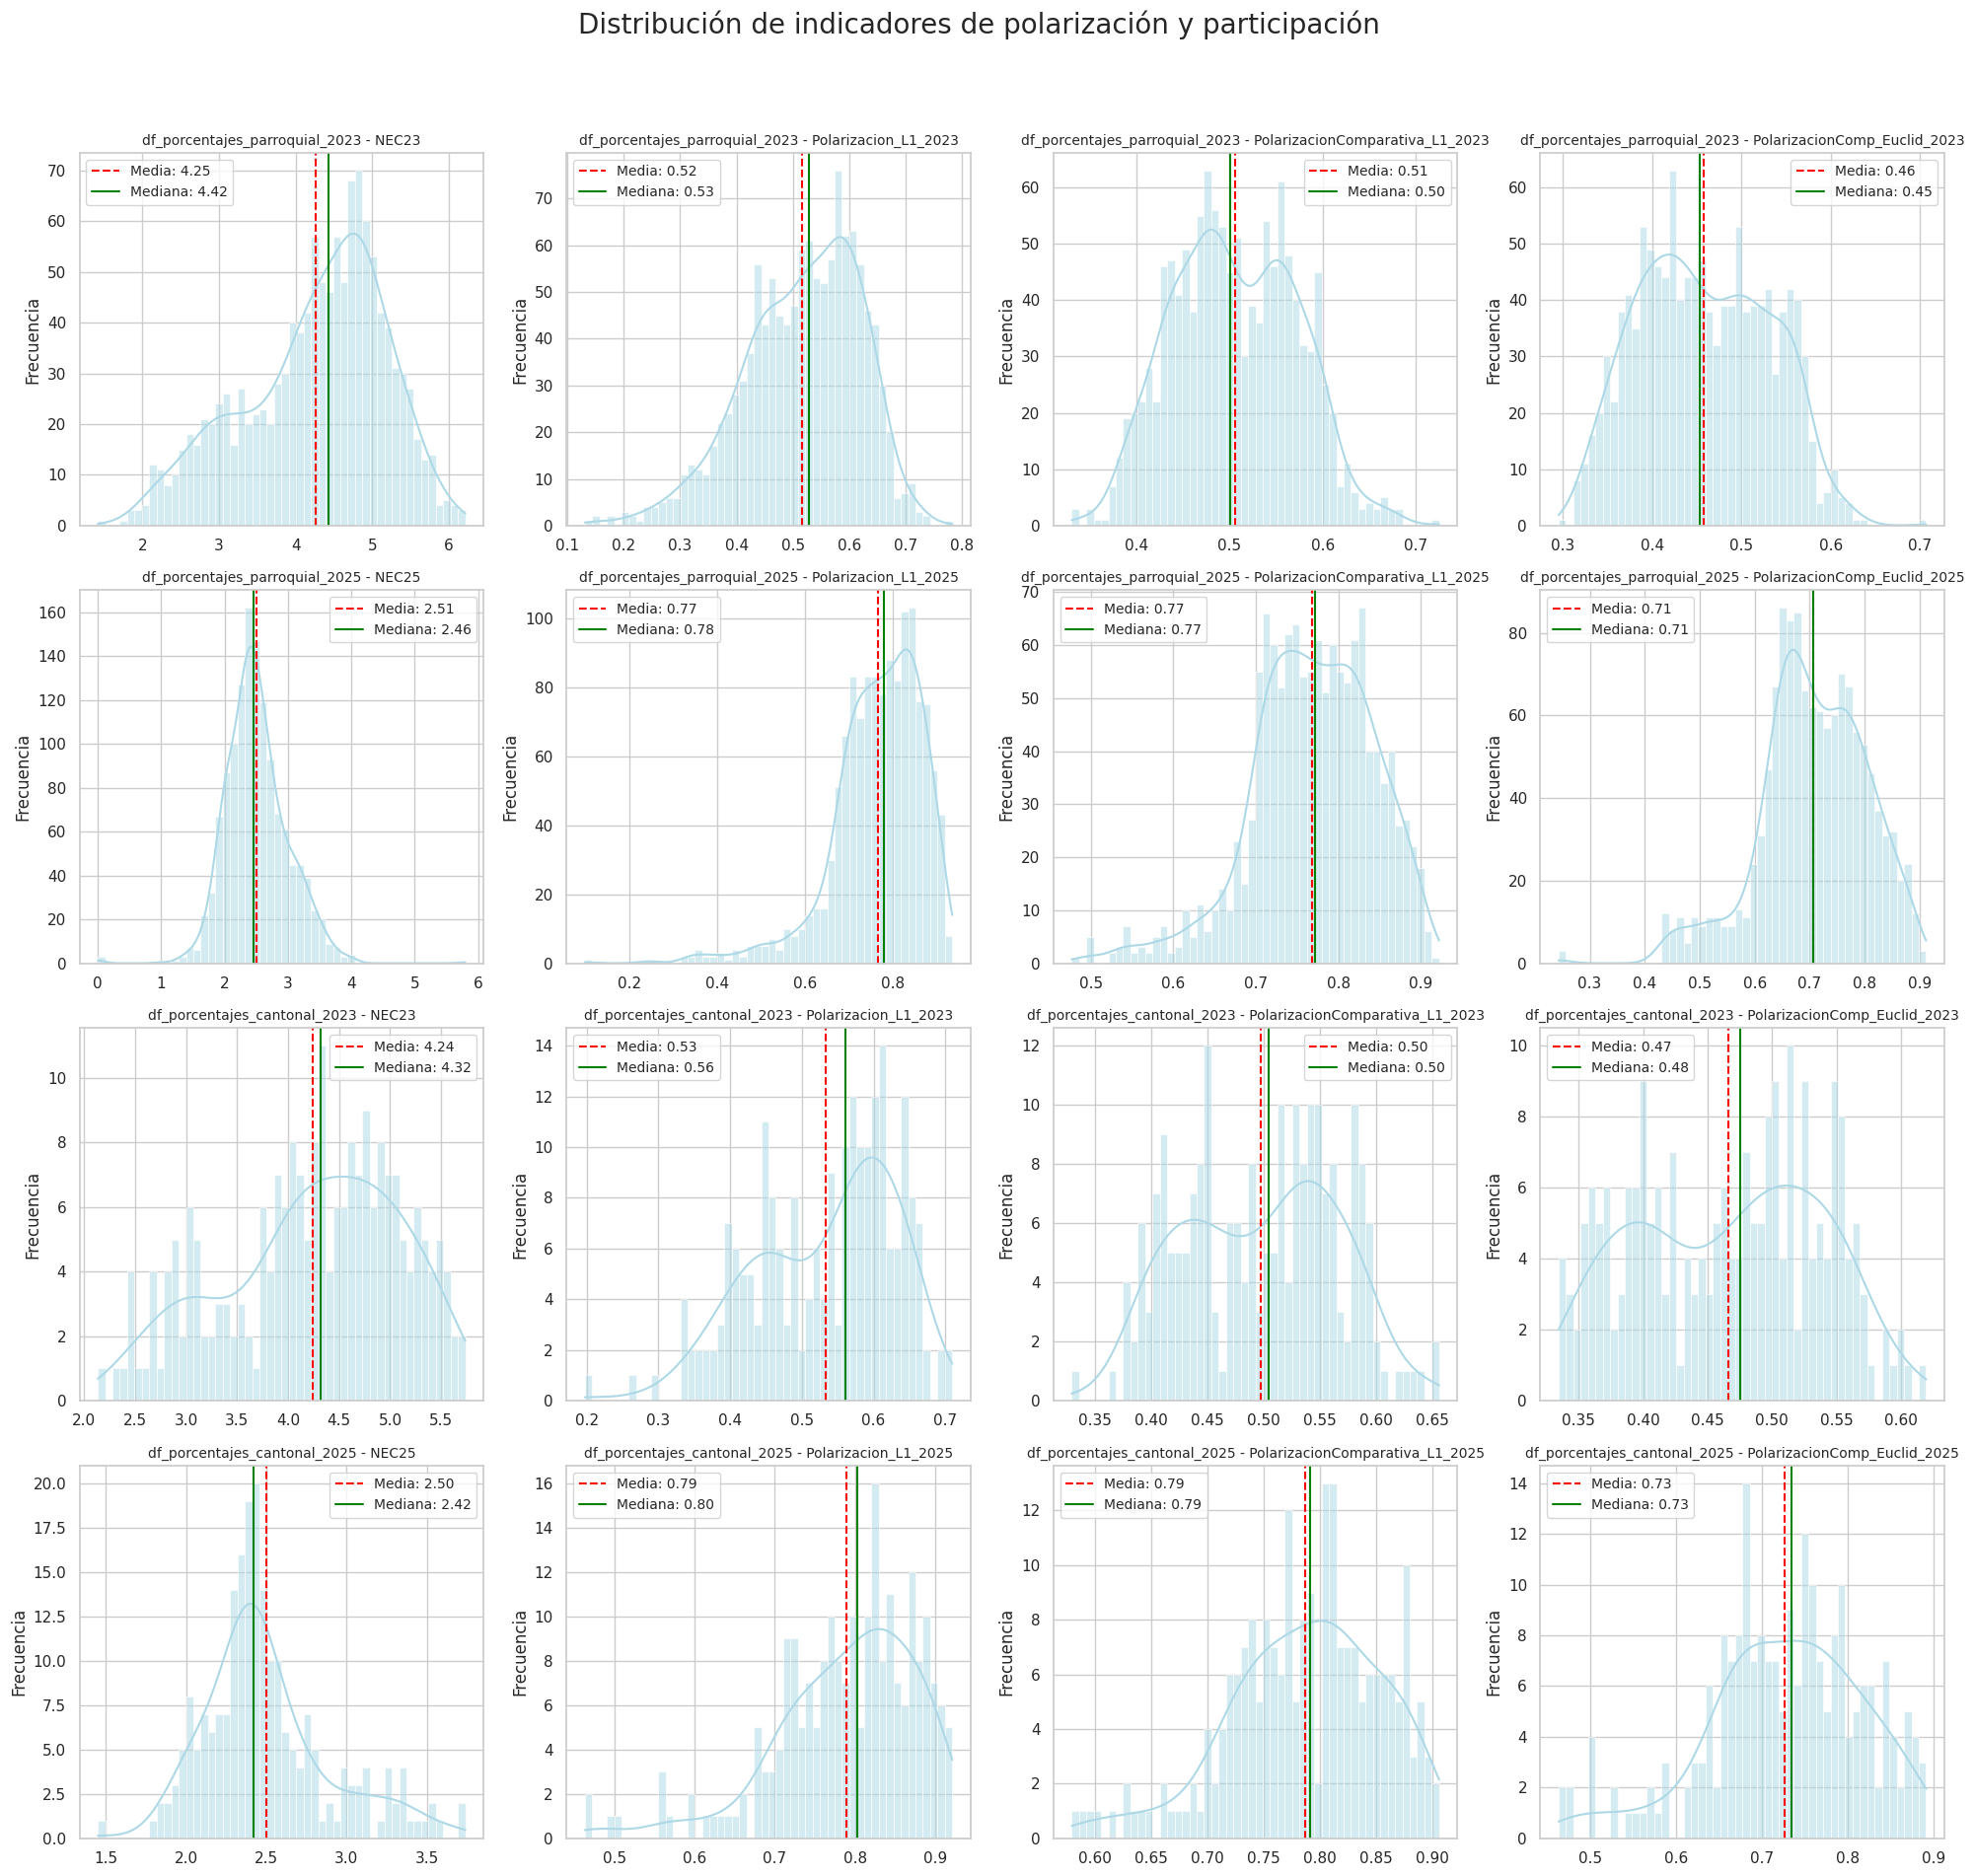

In [26]:
df_info = [
    (df_porcentajes_parroquial_2023, 'df_porcentajes_parroquial_2023'),
    (df_porcentajes_parroquial_2025, 'df_porcentajes_parroquial_2025'),
    (df_porcentajes_cantonal_2023, 'df_porcentajes_cantonal_2023'),
    (df_porcentajes_cantonal_2025, 'df_porcentajes_cantonal_2025'),
]

# Crear figura 4x4
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Distribución de indicadores de polarización y participación', fontsize=20)

# Iterar sobre cada dataframe
for i, (df, nombre_df) in enumerate(df_info):
    indicadores = df.columns[-4:]  # Últimas cuatro columnas
    for j, indicador in enumerate(indicadores):
        ax = axes[i, j]
        sns.histplot(df[indicador].dropna(), bins=50, kde=True, ax=ax, color='lightblue')
        ax.axvline(df[indicador].mean(), color='red', linestyle='--', label=f'Media: {df[indicador].mean():.2f}')
        ax.axvline(df[indicador].median(), color='green', linestyle='-', label=f'Mediana: {df[indicador].median():.2f}')
        ax.set_title(f"{nombre_df} - {indicador}", fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Frecuencia')
        ax.legend(fontsize='small')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [27]:
df_porcentajes_parroquial_2025.to_excel("df_porcentajes_parroquial_2025.xlsx", index=False, float_format="%.5f")
df_porcentajes_parroquial_2023.to_excel("df_porcentajes_parroquial_2023.xlsx", index=False, float_format="%.5f")